In [1]:
%%capture
from notebook import notebookapp
server = list(notebookapp.list_running_servers())[0]

if server['hostname'] == 'localhost':
  # Local environment
  %reload_ext autoreload
  %autoreload 2
  %matplotlib inline
else:
  # Cloud
  !pip install git+https://github.com/fastai/fastai.git
  !curl https://course.fast.ai/setup/colab | bash

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.utils.show_install import *
from shutil import copy, move

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import json

np.random.seed(42)

show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.62.dev0
fastprogress  : 0.2.3
torch         : 1.5.1+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Feb 19 05:26:34 PST 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once i

In [3]:
train_dir = untar_data('https://github.com/zo7/painter-by-numbers/releases/download/data-v1.0/train')
train_dir, len(train_dir.ls())

(PosixPath('/root/.fastai/data/train'), 79433)

In [4]:
base_dir = train_dir.parent
pictures_dir = base_dir/'pictures'
pictures_dir.mkdir(parents = True, exist_ok=True)
pictures_dir

PosixPath('/root/.fastai/data/pictures')

In [5]:
for f in train_dir.ls():
    copy(f, pictures_dir)
len(pictures_dir.ls())

79433

In [6]:
test_dir = untar_data('https://github.com/zo7/painter-by-numbers/releases/download/data-v1.0/test')
test_dir, len(test_dir.ls())

(PosixPath('/root/.fastai/data/test'), 23817)

In [7]:
for f in test_dir.ls():
    copy(f, pictures_dir)
len(pictures_dir.ls())

103250

In [8]:
with urlopen('https://github.com/octopanda4/cnn-art/raw/master/all_data_info.csv.zip') as zip_res:
    with ZipFile(BytesIO(zip_res.read())) as archive:
        archive.extractall(base_dir)

In [9]:
csv = base_dir/'all_data_info.csv'
df = pd.read_csv(csv, low_memory=False)

In [10]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [11]:
style_counts = df['style'].value_counts() # a series of labeled counts of each unique style
print(len(style_counts), style_counts.keys()) # number of unique styles, the different styles

136 Index(['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
       'Post-Impressionism', 'Art Nouveau (Modern)', 'Baroque', 'Surrealism',
       'Symbolism', 'Rococo',
       ...
       'Cartographic Art', 'Nas-Taliq', 'Miserablism', 'Rayonism',
       'Perceptism ', 'Spectralism', 'Kinetic Art', 'Ilkhanid', 'Renaissance',
       'Environmental (Land) Art'],
      dtype='object', length=136)


In [12]:
style_labels = style_counts[style_counts>750].keys().to_list() # list of styles where the num. paintings > 750

In [13]:
len(style_labels) # num. of such styles 

25

In [14]:
# a df of just the styles w/ count >750 and the count of paintings in each style to visualize:
style_counts_df = df.groupby('style')['size_bytes'] \
        .aggregate(['count'])\
        .sort_values(by=['count'], ascending=False)\
        .query('count > 750')
display(style_counts_df)

,count
style,
Impressionism,10643
Realism,10523
Romanticism,9285
Expressionism,7013
Post-Impressionism,5778
Art Nouveau (Modern),4899
Baroque,4400
Surrealism,4167
Symbolism,3476


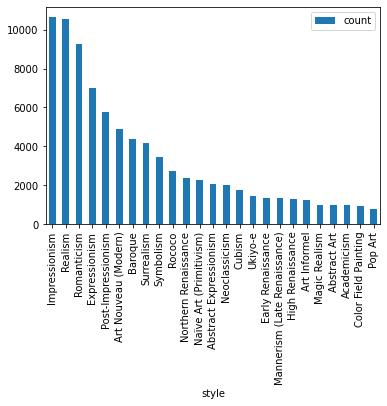

In [15]:
style_counts_df.plot(kind = 'bar') # graph of the number of paintings we have per style
plt.show()

In [16]:
# a df of just the paintings with the selected styles:
df_styles = df.query('style in @style_labels')
len(df_styles) # number of such paintings

84804

In [17]:
# for now, balance dataset by making a sample of the same number of images per style
s_size = 790
df_styles = df_styles.groupby('style')['style','new_filename'].apply(lambda s: s.sample(s_size))
len(df_styles)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


19750

In [18]:
df_styles.tail()

style new_filename
style                              
Ukiyo-e 523    Ukiyo-e    54323.jpg
        398    Ukiyo-e    98553.jpg
        8274   Ukiyo-e    49930.jpg
        71563  Ukiyo-e   100472.jpg
        10928  Ukiyo-e    28146.jpg

In [19]:
data = ImageDataBunch.from_df(df = df_styles, path=pictures_dir, label_col = 'style', 
                              fn_col = 'new_filename', ds_tfms = get_transforms(), 
                              size = 299, bs = 32 # experiment with some different batch sizes
                             ).normalize(imagenet_stats) # uses fast.ai library imagenet_stats to normalize
data # prints num images used for training + num used for validation (auto uses 0.2 for validation)

ImageDataBunch;

Train: LabelList (15800 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Abstract Art,Abstract Art,Abstract Art,Abstract Art,Abstract Art
Path: /root/.fastai/data/pictures;

Valid: LabelList (3950 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Neoclassicism,Abstract Art,Symbolism,Rococo,Northern Renaissance
Path: /root/.fastai/data/pictures;

Test: None

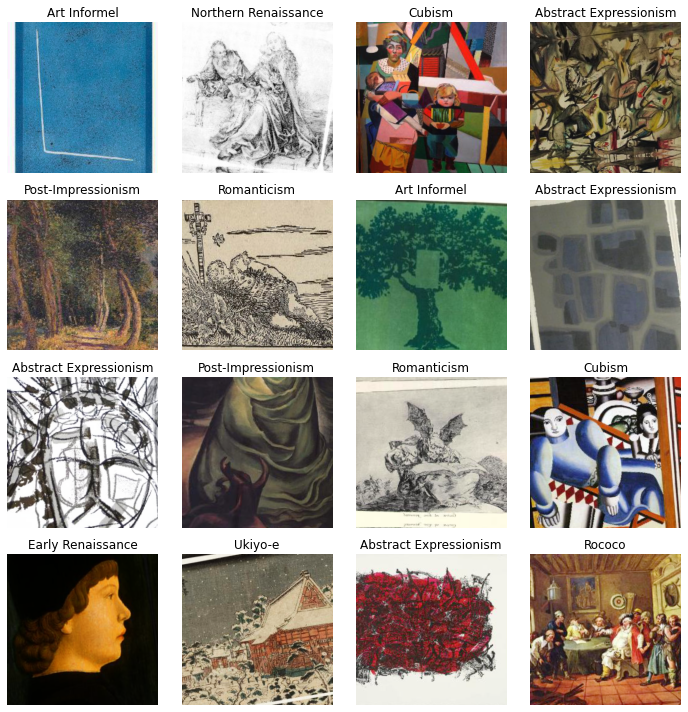

In [20]:
data.show_batch(rows=4, figsize = (10,10)) # shows a small batch of tagged images

In [23]:
# training resnet-50
# we train in two phases: first freeze the body weights + only train the head
# then, unfreeze the layers of the backbome and fine-tune the whole model using learning rates

learner = cnn_learner(data, models.resnet50, metrics = [error_rate,accuracy], callback_fns = ShowGraph) 
# creates an object cut at the last convolutional layer and adds an AdaptiveConcatPool2D layer, 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.883743,2.118375,0.636203,0.363797,04:37
1,2.592671,1.930156,0.589114,0.410886,04:40
2,2.327563,1.844656,0.564304,0.435696,04:50
3,2.157231,1.784471,0.555949,0.444051,04:49
4,2.057779,1.749904,0.549114,0.450886,04:44
5,1.935961,1.700325,0.542025,0.457975,04:44
6,1.857749,1.666051,0.522532,0.477468,04:42
7,1.815961,1.663078,0.529367,0.470633,04:56
8,1.716432,1.623711,0.526835,0.473165,04:42
9,1.757344,1.602474,0.511899,0.488101,04:46


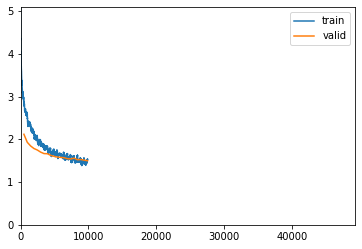

Better model found at epoch 0 with error_rate value: 0.6362025141716003.
Better model found at epoch 1 with error_rate value: 0.5891139507293701.
Better model found at epoch 2 with error_rate value: 0.5643038153648376.
Better model found at epoch 3 with error_rate value: 0.5559493899345398.
Better model found at epoch 4 with error_rate value: 0.549113929271698.
Better model found at epoch 5 with error_rate value: 0.5420253276824951.
Better model found at epoch 6 with error_rate value: 0.5225316286087036.
Better model found at epoch 9 with error_rate value: 0.5118987560272217.
Better model found at epoch 12 with error_rate value: 0.5086075663566589.
Better model found at epoch 13 with error_rate value: 0.503291130065918.
Better model found at epoch 14 with error_rate value: 0.49670886993408203.
Better model found at epoch 15 with error_rate value: 0.48962023854255676.
Better model found at epoch 16 with error_rate value: 0.4881012737751007.
Better model found at epoch 17 with error_rate

In [24]:

learner.fit_one_cycle(100, callbacks=[callbacks.SaveModelCallback(learner, every = 'improvement', mode = 'min',
                                                               monitor = 'error_rate', name = 'style-r50-stage-1')]) 
# only trains the head and saves every improvement
# uses Leslie Smith's one cycle policy -- default stop value: 0.003 -- with 6 epochs

In [ ]:
learner.load('style-r50-stage-1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')